# Semantic Segmentation: MXNet algorthimic comparison on Sagemaker


Computer vision models have exploded in recent years. From Google’s self-driving cars and Tesla’s autopilot mode to Amazon’s Virtual Mirror, computer vision has transformed the face of modern technology. But machine learning image processing isn’t as easy as it may seem.

Training and validating computer vision and machine learning algorithms as well as image processing techniques require massive amounts of annotated data and high quality image annotation tool. That’s where image and video segmentation comes in.

Segmentation allows us to organize the data contained within images and videos into meaningful categories. Image classification and object detection may tell us the presence and location of certain objects. Segmentation allows us to dive deeper even in a real time. This type of segmentation involves grouping each pixel under a particular label. For example, any pixel belonging to a dog would be assigned under the same “dog” category.



Hi, I'm Abhishek Gautam aka DragoKami, I've created this notebook to understand how MXNet's algorithms work on same images and compare them side by side.


## Import Libraries

In [1]:
import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker
import glob

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image, ImageDraw, ImageFont

## About Data

### Using OXFORD-IIIT PET Dataset
----------------------------------------------
Credits: Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar

urls = 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz'

### Contents:
---------------
* trimaps/       - Trimap annotations for every image in the dataset
                       Pixel Annotations: 1: Foreground 2:Background 3: Not classified
          
* xmls/		      - Head bounding box annotations in PASCAL VOC Format

* list.txt	      - Combined list of all images in the dataset
                       Each entry in the file is of following nature:
                           Image CLASS-ID SPECIES BREED ID
                           ID: 1:37 Class ids
                           SPECIES: 1:Cat 2:Dog
                           BREED ID: 1-25:Cat 1:12:Dog
                       All images with 1st letter as captial are cat images while
                       images with small first letter are dog images.
                       
* trainval.txt	  - Files describing splits used in the paper. However, random splits are better.
* test.txt	       


## Download Data

In [2]:
urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


## Visualize Data

### Check files and folder structure

In [3]:
# The data folder has two sub-folders
print(glob.glob("data/*"))

['data/images', 'data/annotations']


In [4]:
print(glob.glob("data/images/*"))

['data/images/german_shorthaired_198.jpg', 'data/images/wheaten_terrier_13.jpg', 'data/images/samoyed_114.jpg', 'data/images/german_shorthaired_103.jpg', 'data/images/Birman_176.jpg', 'data/images/Birman_169.jpg', 'data/images/staffordshire_bull_terrier_152.jpg', 'data/images/miniature_pinscher_133.jpg', 'data/images/scottish_terrier_99.jpg', 'data/images/american_pit_bull_terrier_66.jpg', 'data/images/saint_bernard_35.jpg', 'data/images/beagle_33.jpg', 'data/images/Bombay_118.jpg', 'data/images/keeshond_139.jpg', 'data/images/staffordshire_bull_terrier_108.jpg', 'data/images/Egyptian_Mau_93.jpg', 'data/images/Maine_Coon_1.jpg', 'data/images/Sphynx_231.jpg', 'data/images/wheaten_terrier_63.jpg', 'data/images/scottish_terrier_165.jpg', 'data/images/miniature_pinscher_13.jpg', 'data/images/japanese_chin_62.jpg', 'data/images/samoyed_166.jpg', 'data/images/leonberger_131.jpg', 'data/images/Birman_97.jpg', 'data/images/japanese_chin_128.jpg', 'data/images/shiba_inu_208.jpg', 'data/images/s

In [5]:
print(glob.glob("data/annotations/*"))

['data/annotations/xmls', 'data/annotations/test.txt', 'data/annotations/trainval.txt', 'data/annotations/trimaps', 'data/annotations/list.txt', 'data/annotations/README']


In [6]:
print(glob.glob("data/annotations/trimaps/*"))

['data/annotations/trimaps/pomeranian_90.png', 'data/annotations/trimaps/Persian_88.png', 'data/annotations/trimaps/Egyptian_Mau_4.png', 'data/annotations/trimaps/great_pyrenees_2.png', 'data/annotations/trimaps/havanese_78.png', 'data/annotations/trimaps/Abyssinian_49.png', 'data/annotations/trimaps/Bombay_77.png', 'data/annotations/trimaps/Persian_135.png', 'data/annotations/trimaps/saint_bernard_22.png', 'data/annotations/trimaps/miniature_pinscher_141.png', 'data/annotations/trimaps/english_setter_79.png', 'data/annotations/trimaps/Siamese_64.png', 'data/annotations/trimaps/Russian_Blue_109.png', 'data/annotations/trimaps/British_Shorthair_34.png', 'data/annotations/trimaps/Birman_133.png', 'data/annotations/trimaps/shiba_inu_115.png', 'data/annotations/trimaps/saint_bernard_156.png', 'data/annotations/trimaps/staffordshire_bull_terrier_48.png', 'data/annotations/trimaps/havanese_66.png', 'data/annotations/trimaps/wheaten_terrier_54.png', 'data/annotations/trimaps/beagle_86.png', '

#### Turns out images are in JPG whereas annotation maps in PNG

In [6]:
%matplotlib inline
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [7]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


#### Visualize an image

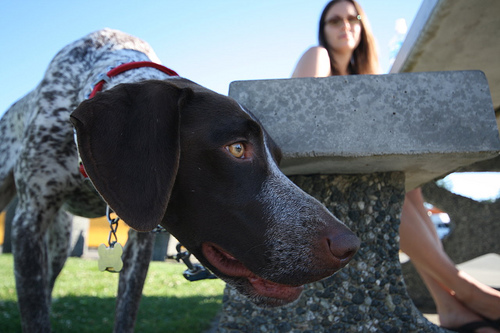

In [8]:
img = Image.open(image_dir+images[0])
img.show()

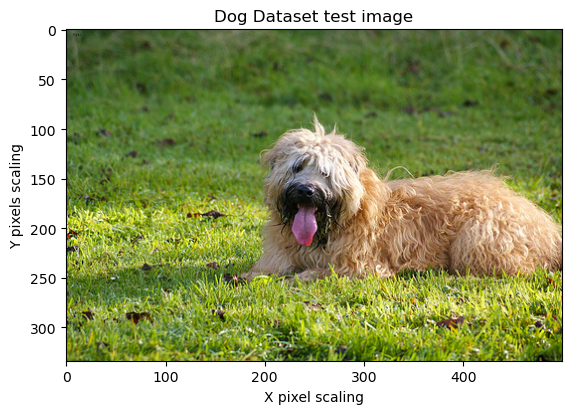

In [9]:
plt.title("Dog Dataset test image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
image = mpimg.imread(image_dir+images[1])
plt.imshow(image)
plt.show()

#### Visualize map and image side by side

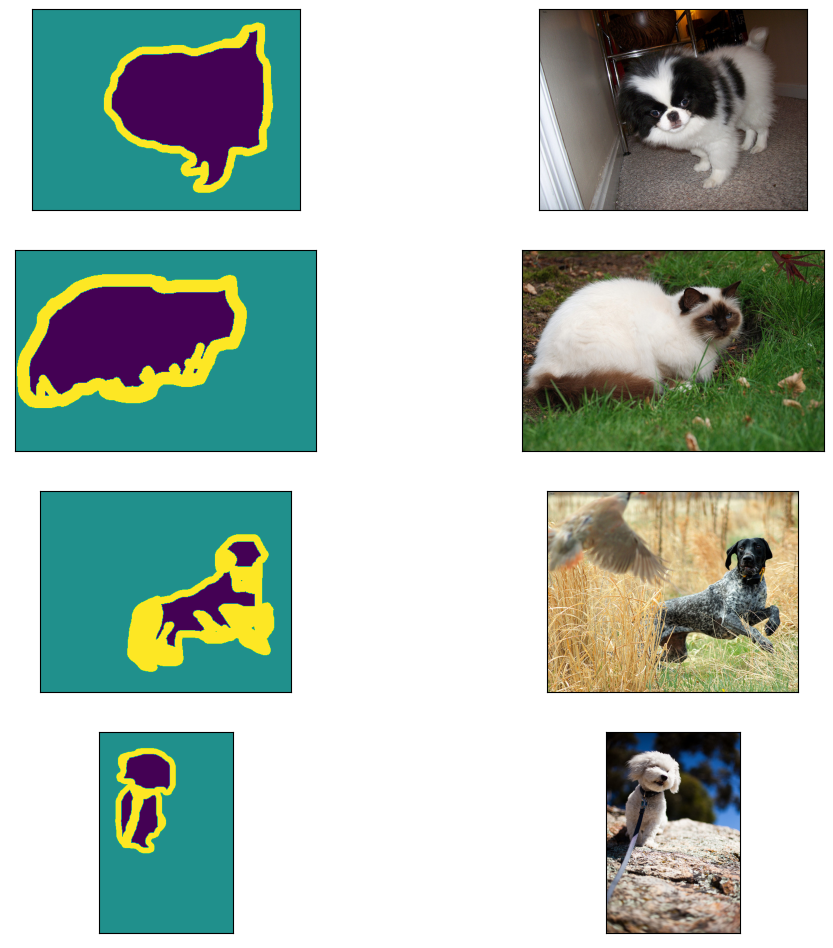

In [10]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

#### Check unique colors in maps

There are 3 unique colors in our map which signifies there are three regions for segments.

* Outer-Segment: (Blue shade) Denotes backgound noise
* Middle-Segment: (Yellow) Undeterministic pixels, or boundary pixels, these are part of object.
* Inner-Segment: (Purple) The object itself, in our case dog or cat

All in all the desired segment is marked by middle and inner segment combined.

In [11]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


## Sagemaker Activities
#### These include setup, data preparation, creating estimator, setting hyperparameters, creating data channels, training, and deployment of model

### Setup

In [12]:
role = sagemaker.get_execution_role()
sm_session = sagemaker.Session()
region = boto3.Session().region_name
bucket_name = 'dragokami-semseg-sagemaker'
training_image = sagemaker.image_uris.retrieve('semantic-segmentation', region)
print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:1


In [13]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

### Preparing data for training

In [14]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:19<00:00, 378.81it/s]


In [15]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [16]:
print(len(train_annots), len(train_images))

5588 5588


### Uploading data to S3

In [17]:
%%time

print('Starting upload...')
s3_train_path = sm_session.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sm_session.upload_data(path='train_annotation', bucket=bucket_name,
                                     key_prefix='train_annotation')
print('Training Annotations uploaded')
s3_validation_path = sm_session.upload_data(path='validation', bucket=bucket_name,
                                      key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sm_session.upload_data(path='validation_annotation', bucket=bucket_name,
                                          key_prefix='validation_annotation')
print('Validation Annotations uploaded')

Starting upload...
Training images uploaded
Training Annotations uploaded
Validation images uploaded
Validation Annotations uploaded
CPU times: user 1min 20s, sys: 7.38 s, total: 1min 28s
Wall time: 15min 13s


In [18]:
s3_validation_annotation_path

's3://dragokami-semseg-sagemaker/validation_annotation'

### Create the estimators

##### Model for FCN

In [19]:
model = Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',  # Used for GPU
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://'+bucket_name+'/output',
    sagemaker_session=sm_session
)

In [20]:
model.set_hyperparameters(
    backbone='resnet-50', # This is the encoder. Other option is resnet-50
    algorithm='fcn', # This is the decoder. Other option is 'psp' and 'deeplab'                             
    use_pretrained_model='True', # Use the pre-trained model.
    crop_size=240, # Size of image random crop.                             
    num_classes=4, # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10, # Number of epochs to run.
    learning_rate=0.0001,                             
    optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
    mini_batch_size=16, # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=3, # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
    num_training_samples=len(train_images)
)

#### Model for PSP

In [21]:
model2 = Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',  # Used for GPU
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://'+bucket_name+'/output',
    sagemaker_session=sm_session
)

In [22]:
model2.set_hyperparameters(
    backbone='resnet-50', # This is the encoder. Other option is resnet-50
    algorithm='psp', # This is the decoder. Other option is 'fcn' and 'deeplab'                             
    use_pretrained_model='True', # Use the pre-trained model.
    crop_size=240, # Size of image random crop.                             
    num_classes=4, # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10, # Number of epochs to run.
    learning_rate=0.0001,                             
    optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
    mini_batch_size=16, # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=3, # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
    num_training_samples=len(train_images)
)

#### Model for Deeplab

In [23]:
model3 = Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',  # Used for GPU
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://'+bucket_name+'/output',
    sagemaker_session=sm_session
)

In [24]:
model3.set_hyperparameters(
    backbone='resnet-50', # This is the encoder. Other option is resnet-50
    algorithm='deeplab', # This is the decoder. Other option is 'psp' and 'fcn'                             
    use_pretrained_model='True', # Use the pre-trained model.
    crop_size=240, # Size of image random crop.                             
    num_classes=4, # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10, # Number of epochs to run.
    learning_rate=0.0001,                             
    optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
    mini_batch_size=16, # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=3, # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
    num_training_samples=len(train_images)
)

### Data channels for the estimator

In [25]:
train_data = TrainingInput(s3_train_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = TrainingInput(s3_validation_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')

In [26]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

### Model Training

In [27]:
model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: semantic-segmentation-2023-02-26-05-38-28-240


2023-02-26 05:38:28 Starting - Starting the training job.........
2023-02-26 05:39:38 Starting - Preparing the instances for training......
2023-02-26 05:40:51 Downloading - Downloading input data......
2023-02-26 05:41:46 Training - Downloading the training image........................
2023-02-26 05:45:48 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sun Feb 26 05:46:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.07    Driver Version: 515.65.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
| 

In [28]:
model2.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: semantic-segmentation-2023-02-26-06-22-30-232


2023-02-26 06:22:30 Starting - Starting the training job...
2023-02-26 06:22:57 Starting - Preparing the instances for training.........
2023-02-26 06:24:05 Downloading - Downloading input data...
2023-02-26 06:24:50 Training - Downloading the training image...........................
2023-02-26 06:29:12 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sun Feb 26 06:29:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.07    Driver Version: 515.65.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|     

In [29]:
model3.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: semantic-segmentation-2023-02-26-07-27-12-198


2023-02-26 07:27:12 Starting - Starting the training job...
2023-02-26 07:27:37 Starting - Preparing the instances for training......
2023-02-26 07:28:40 Downloading - Downloading input data.........
2023-02-26 07:29:45 Training - Downloading the training image.....................
2023-02-26 07:33:42 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sun Feb 26 07:34:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.07    Driver Version: 515.65.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|      

### Deploy Models

In [30]:
# Deploying FCN model
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

INFO:sagemaker:Creating model with name: semantic-segmentation-2023-02-26-08-16-22-604
INFO:sagemaker:Creating endpoint-config with name semantic-segmentation-2023-02-26-08-16-22-604
INFO:sagemaker:Creating endpoint with name semantic-segmentation-2023-02-26-08-16-22-604


-----------------!
Model deployed!


In [31]:
# Deploying PSP model
deployed_model2 = model2.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel2 deployed!')

INFO:sagemaker:Creating model with name: semantic-segmentation-2023-02-26-08-25-14-464
INFO:sagemaker:Creating endpoint-config with name semantic-segmentation-2023-02-26-08-25-14-464
INFO:sagemaker:Creating endpoint with name semantic-segmentation-2023-02-26-08-25-14-464


-----------------!
Model2 deployed!


In [32]:
# Deploying Deeplab model
deployed_model3 = model3.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel3 deployed!')

INFO:sagemaker:Creating model with name: semantic-segmentation-2023-02-26-08-35-43-653
INFO:sagemaker:Creating endpoint-config with name semantic-segmentation-2023-02-26-08-35-43-653
INFO:sagemaker:Creating endpoint with name semantic-segmentation-2023-02-26-08-35-43-653


-----------------!
Model3 deployed!


## Time to test the generated segmentations

In [33]:
# Checking number of images in validation directory
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1802


### Testing for one image at random index e.g. 3

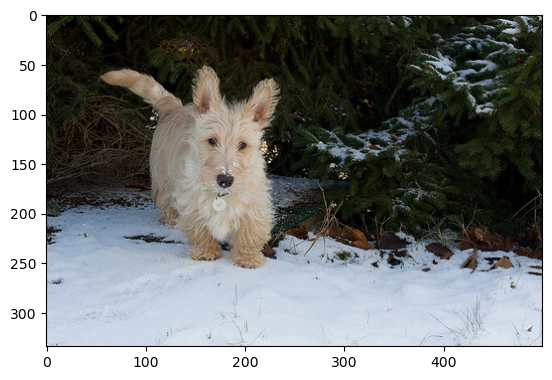

In [37]:
index = 3
image_path = os.path.join(image_dir, images[index])
with open(image_path, 'rb') as f:
    b = bytearray(f.read())
plt.imshow(plt.imread(image_path));

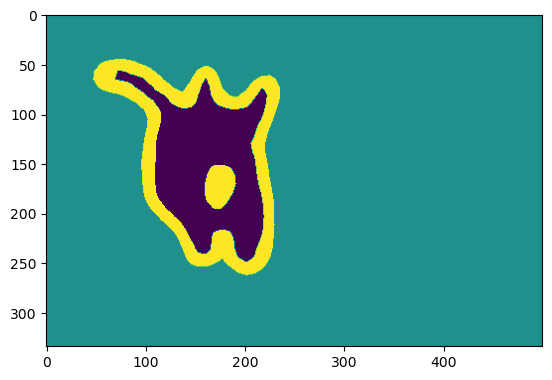

In [38]:
results = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept' : 'image/png'})
mask = np.array(Image.open(io.BytesIO(results)))
plt.imshow(mask);

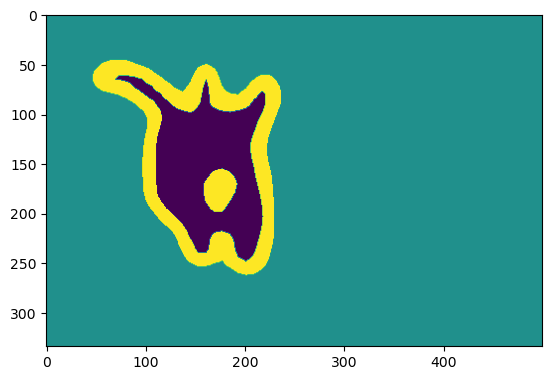

In [39]:
results = deployed_model2.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept' : 'image/png'})
mask = np.array(Image.open(io.BytesIO(results)))
plt.imshow(mask);

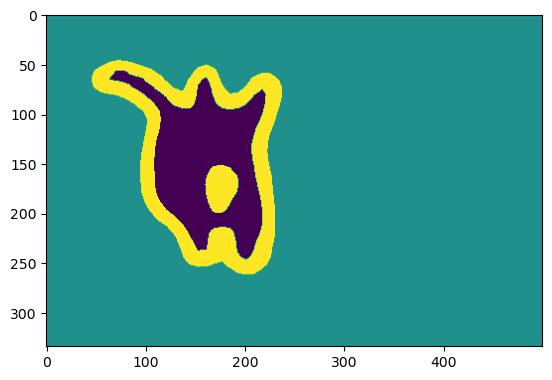

In [40]:
results = deployed_model3.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept' : 'image/png'})
mask = np.array(Image.open(io.BytesIO(results)))
plt.imshow(mask);

## Visualization of Generated Segmentations for Predictions

#### Random Segmentations for FCN

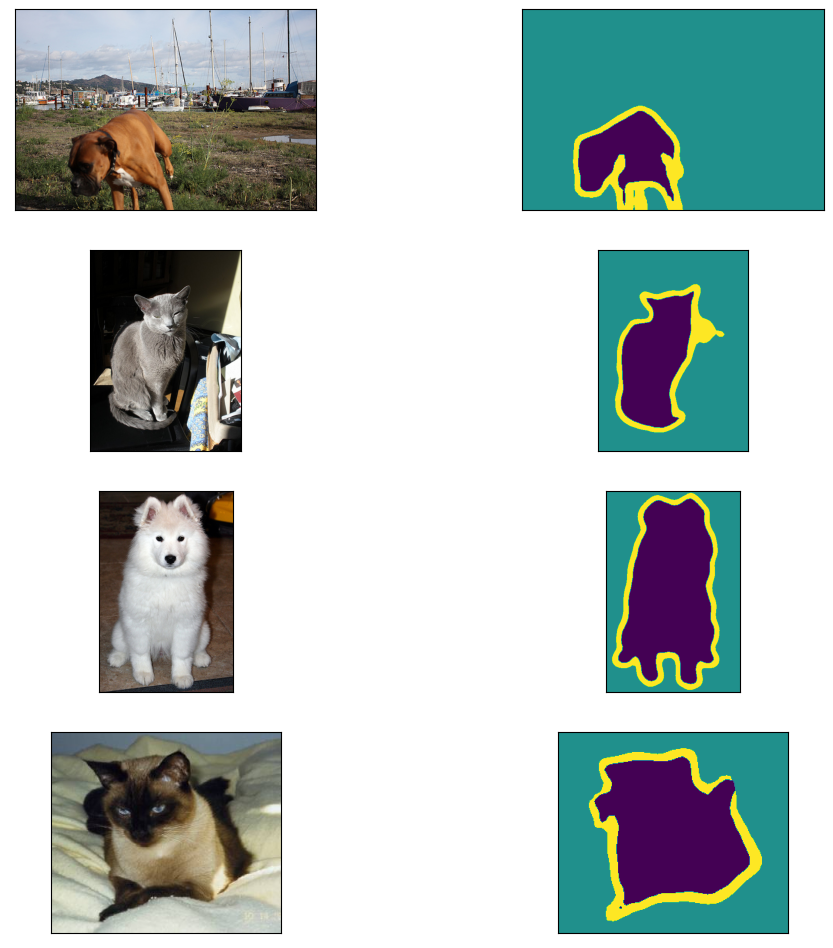

In [41]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    results = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept' : 'image/png'})
    mask = np.array(Image.open(io.BytesIO(results)))
    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(image_path))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask)
plt.show()

#### Random outputs from generated Segmentations PSP

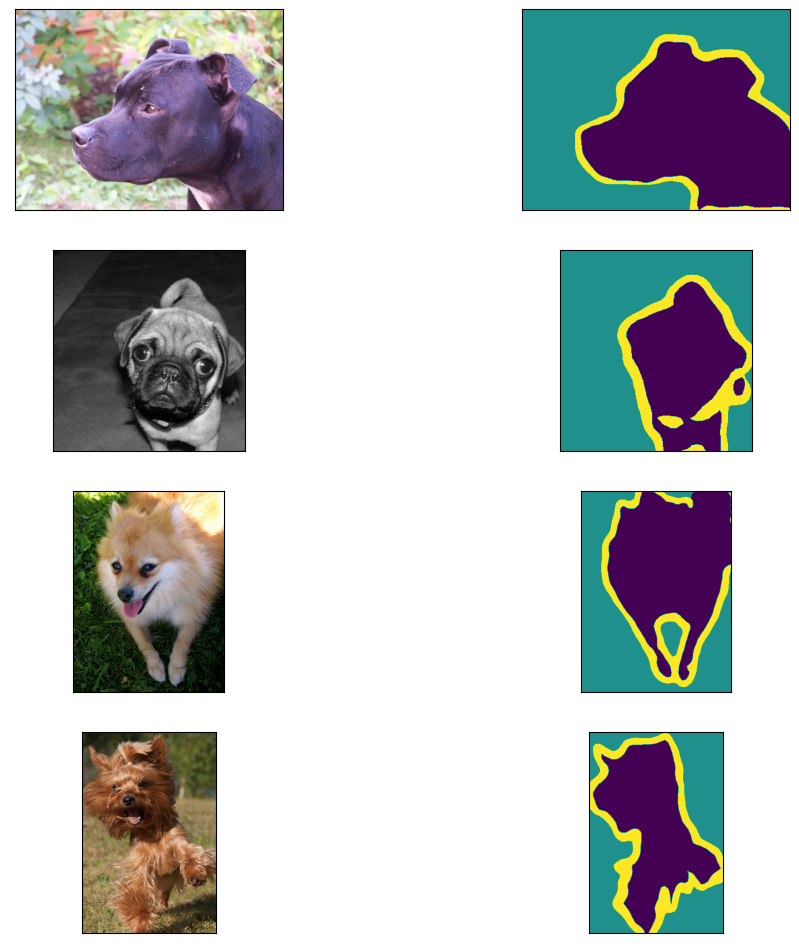

In [42]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    results = deployed_model2.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept' : 'image/png'})
    mask = np.array(Image.open(io.BytesIO(results)))
    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(image_path))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask)
plt.show()

#### Random from Deeplab

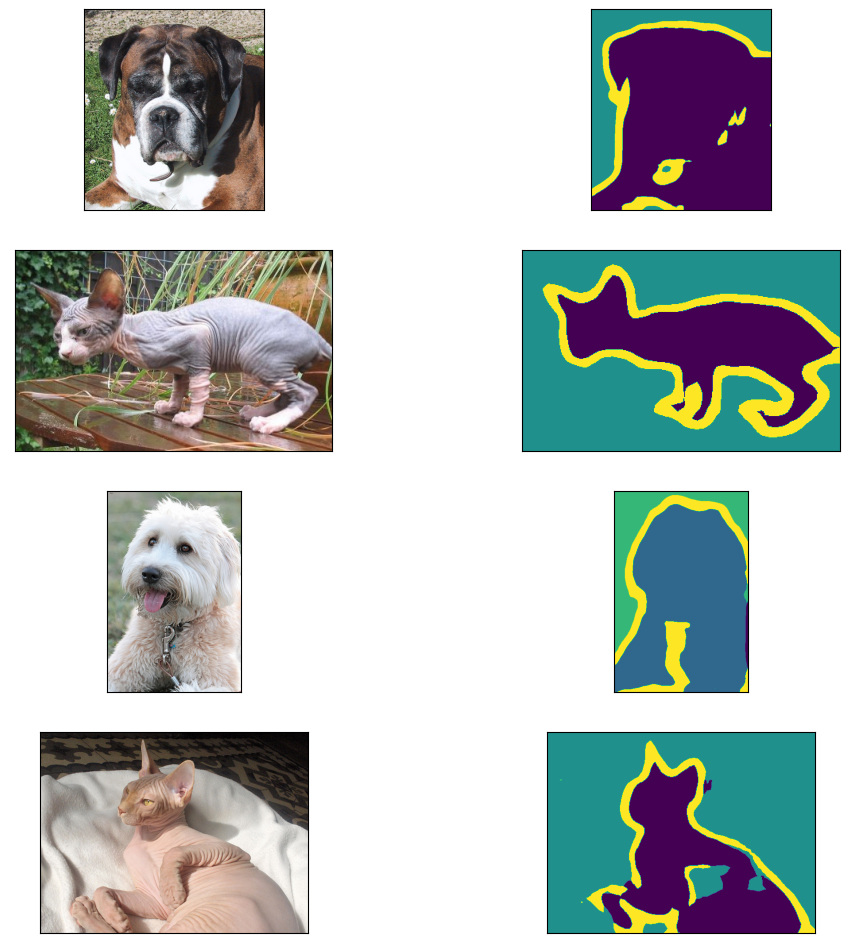

In [43]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    results = deployed_model3.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept' : 'image/png'})
    mask = np.array(Image.open(io.BytesIO(results)))
    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(image_path))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask)
plt.show()

## A Side-by-side compaison of generated segments from all three algorithms

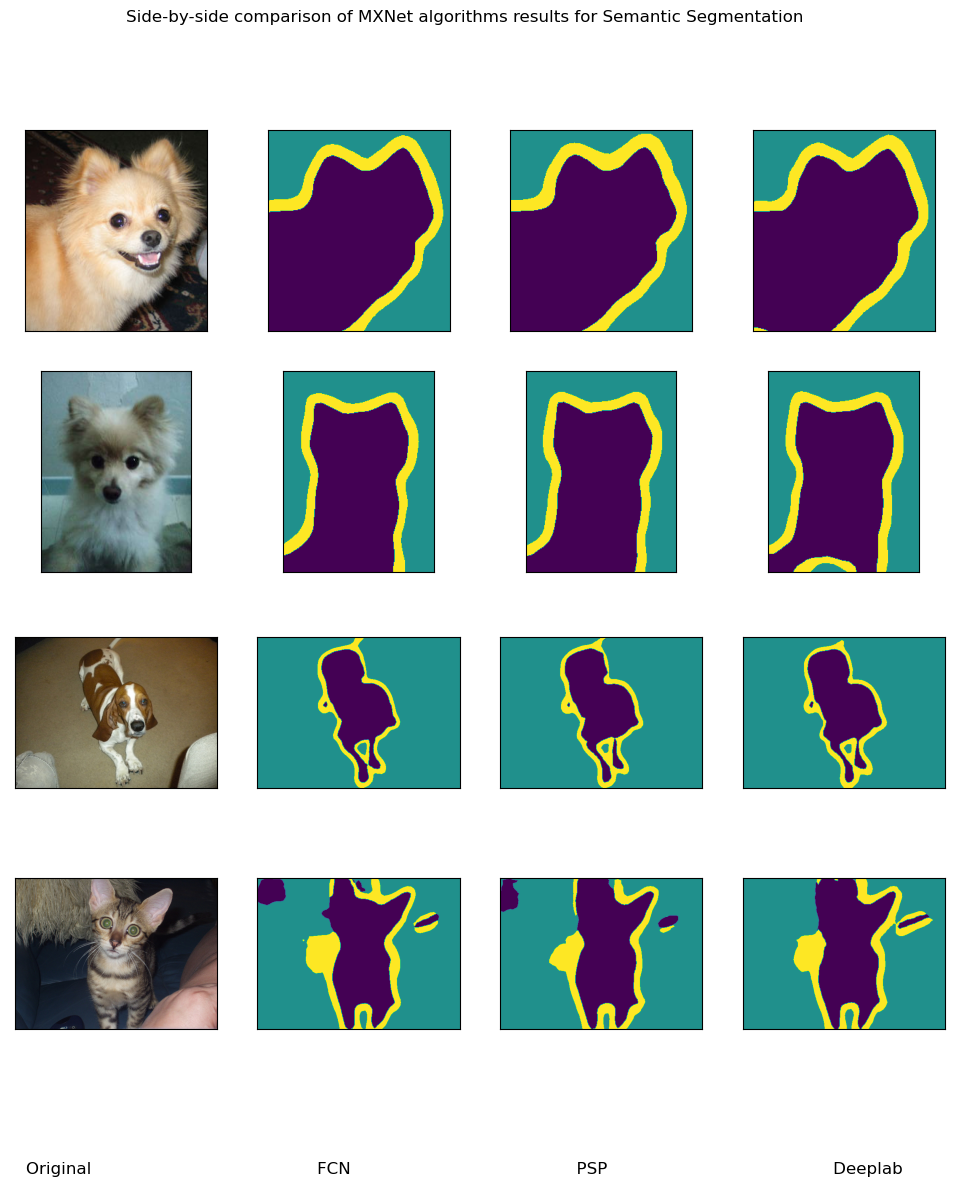

In [44]:
plt.figure(figsize=(12, 12))
plt.suptitle("Side-by-side comparison of MXNet algorithms results for Semantic Segmentation")

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_path = os.path.join(image_dir, images[index])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    
    results_fcn = deployed_model.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept' : 'image/png'})
    mask_fcn = np.array(Image.open(io.BytesIO(results_fcn)))
    
    results_psp = deployed_model2.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept' : 'image/png'})
    mask_psp = np.array(Image.open(io.BytesIO(results_psp)))
    
    results_deeplab = deployed_model3.predict(b, initial_args={'ContentType': 'image/jpeg', 'Accept' : 'image/png'})
    mask_deeplab = np.array(Image.open(io.BytesIO(results_deeplab)))
    
    plt.subplot(4, 4, 1 + i*4)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(image_path))
    plt.subplot(4, 4, 2 + i*4)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask_fcn)
    plt.subplot(4, 4, 3 + i*4)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask_psp)
    plt.subplot(4, 4, 4 + i*4)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask_deeplab)
    #plt.imshow(mask)
plt.figtext(0.5, 0.01, "Original                                           FCN                                           PSP                                           Deeplab", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [45]:
deployed_model.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: semantic-segmentation-2023-02-26-08-16-22-604
INFO:sagemaker:Deleting endpoint with name: semantic-segmentation-2023-02-26-08-16-22-604


In [46]:
deployed_model2.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: semantic-segmentation-2023-02-26-08-25-14-464
INFO:sagemaker:Deleting endpoint with name: semantic-segmentation-2023-02-26-08-25-14-464


In [47]:
deployed_model3.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: semantic-segmentation-2023-02-26-08-35-43-653
INFO:sagemaker:Deleting endpoint with name: semantic-segmentation-2023-02-26-08-35-43-653


## Observations(taken by keeping other hyperparameters same)

* For FCN \
    validation pixel_accuracy: `0.9282207128420398` \
    validation mIOU: `0.6092121799076315` 

    
* For PSP \
    validation pixel_accuracy: `0.9278333376520177` \
    validation mIOU: `0.6098346020806233` 
    
    
* For Deeplab \
    validation pixel_accuracy: `0.9277412039196379` \
    validation mIOU: `0.6102908878955752`